### Main Idea

The section introduces weight decay as a regularization technique to combat overfitting. While collecting more training data can help, it may not always be feasible due to resource or time constraints. Instead, the focus is on adjusting model complexity when the available data is fixed. One common approach is limiting the number of features, as demonstrated in the polynomial regression example. However, simply discarding features may not be sufficient, especially when dealing with high-dimensional input.

In such cases, the complexity of the model increases rapidly with the degree of monomials (products of variable powers). For example, the number of monomials of degree \(d\) grows exponentially with \(d\). Therefore, weight decay serves as a more precise tool to manage and adjust model complexity.



In [2]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successful

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

### Weight Decay and Norm

Weight decay, also called L2 regularization, restricts the values that model parameters can take rather than directly reducing the number of parameters. This method is widely used, especially in models optimized by minibatch stochastic gradient descent. The main idea is that simpler functions, like f = 0 (where all parameters are zero), are preferable, and the complexity of a function can be measured by how far its parameters are from zero.

To measure this distance, we use norms. The two most common norms are:

- **L1 norm**: This is the sum of the absolute values of the parameters. It encourages sparsity in the model, meaning some parameters are set to zero.

- **L2 norm**: This is the sum of the squared values of the parameters. It penalizes larger weights more heavily than the L1 norm and encourages smaller weight values overall.

In weight decay, the L2 norm of the weight vector is added as a penalty term to the loss function. The new objective becomes the original loss plus the penalty term. This discourages large weights and helps prevent overfitting by ensuring the model does not rely too heavily on any one parameter.


The original loss function for linear regression is:

$$
L(w, b) = \frac{1}{n} \sum_{i=1}^{n} \frac{1}{2} (w \cdot x^{(i)} + b - y^{(i)})^2
$$

Where:
- \( x^{(i)} \) are the features,
- \( y^{(i)} \) is the label for any data example \( i \),
- \( w \) and \( b \) are the weight and bias parameters, respectively.

To add weight decay, we introduce a regularization term. The updated loss function with weight decay becomes:

$$
L(w, b) + \frac{\lambda}{2} \|w\|^2
$$

Where:
- lambda  is the regularization constant (a nonnegative hyperparameter),
- ||w||^2  is the squared L2 norm of the weight vector.

For lambda = 0 , we recover the original loss function. For lambda > 0 , we penalize the size of the weight vector.

### Summary: ℓ1 vs ℓ2 Regularization

The choice between ℓ2 and ℓ1 regularization depends on the desired behavior of the model.

- **ℓ2 regularization** (Ridge Regression) places a larger penalty on large components of the weight vector. This encourages the model to distribute weight more evenly across a larger number of features, making it more robust to measurement errors in individual variables.

- **ℓ1 regularization** (Lasso Regression) leads to sparse models by setting some weights to zero. This is useful for **feature selection**, as it allows the model to focus on only the most important features. If the model uses only a few features, we can avoid the cost of collecting, storing, or transmitting data for the unused features.

Thus, while ℓ2 is often used to make models more stable and robust, ℓ1 is preferred when feature selection is important.


### Minibatch Stochastic Gradient Descent Update for ℓ2 Regularized Linear Regression

$$
 \frac{1}{n} \sum_{i=1}^{n} \left( w \cdot x^{(i)} + b - y^{(i)} \right)^2+ \frac{1}{2}\lambda \|w\|^2
$$

#### Step 1: Gradient of the Loss Function
To update the weights using gradient descent, we compute the gradient of the loss function with respect to `w` and `b`.

The gradient of the **MSE loss** with respect to `w` is:

$$
\frac{\partial L(w, b)}{\partial w} = \frac{2}{n} \sum_{i=1}^{n} \left( w \cdot x^{(i)} + b - y^{(i)} \right) x^{(i)}
$$



#### Step 2: Minibatch Stochastic Gradient Descent (SGD)
In **minibatch SGD**, we use a random subset (minibatch) of training data. Let `B` represent a minibatch of size `|B|`. The gradient for a minibatch is:

$$
\frac{1}{|B|} \sum_{i \in B} \left( w \cdot x^{(i)} + b - y^{(i)} \right) x^{(i)} +  \lambda w
$$

#### Step 4: Update Rule for Stochastic Gradient Descent
In **SGD**, we update the weights `w` by subtracting the gradient scaled by the learning rate `η`:


$$
w \leftarrow w - \eta \left[ \frac{1}{|B|} \sum_{i \in B} \left( w \cdot x^{(i)} + b - y^{(i)} \right) x^{(i)} \right] - \eta \cdot  \lambda w
$$

#### Simplifying the update:
$$
w \leftarrow (1 - \eta \lambda) w - \eta \left( \frac{1}{|B|} \sum_{i \in B} \left( w \cdot x^{(i)} + b - y^{(i)} \right) x^{(i)} \right)
$$


#### Summary of the Update Formula
- **First term**: The factor `(1 - ηλ)` shrinks the weight vector towards zero at each step (regularization).
- **Second term**: The second part updates the weights based on the gradient of the MSE loss computed over the minibatch `B`.

Thus, the final update rule becomes:

$$
w \leftarrow (1 - \eta \lambda) w - \eta \left( \frac{1}{|B|} \sum_{i \in B} \left( w \cdot x^{(i)} + b - y^{(i)} \right) x^{(i)} \right)
$$






- Whether or not to include a bias penalty can vary across different implementations and layers of a neural network.
- Typically, the bias term is **not regularized**.
- While **regularization** might not always be the same as **weight decay** for other optimization algorithms, the core idea remains: **shrinking the size of weights** to prevent overfitting.

In [4]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs) #creates a tensor of size (n, num_inputs) filled with random numbers sampled from a normal distribution with a mean of 0 and a standard deviation of 1.
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

##Weight Decay From Scratch

In [5]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

    # w ** 2 calculates the element-wise square of each element in the tensor w
    # .sum() sums up all the values in the resulting tensor after squaring each element.

In [6]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +
                self.lambd * l2_penalty(self.w))

In [7]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

In [8]:
def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

L2 norm of w: 0.012946183793246746


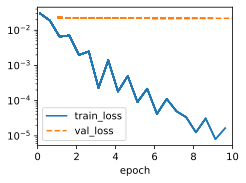

In [9]:
# training qwithout regularization
train_scratch(0)


L2 norm of w: 0.001673594699241221


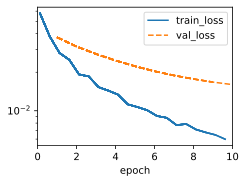

In [10]:
#Using weight decay

train_scratch(3)


##Concise Implementation

In [12]:
class WeightDecay(d2l.LinearRegression):
  def __init__(self,wd,lr):
    super().__init__(lr)
    self.save_hyperparameters()
    self.wd=wd #wd means lambda

  def configure_optimizers(self):
    return torch.optim.SGD([{'params':self.net.weight,'weight_decay':self.wd},{'params':self.net.bias}],lr=self.lr) #The optimizer takes in a list of dictionaries, each defining a group of parameters to optimize

L2 norm of w: 0.015322761610150337


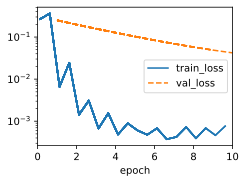

In [13]:
model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))